# 时间感知GRU-DDPG控制系统

本notebook实现了支持时间步长自适应的GRU-DDPG算法，专门用于解决实际控制系统中采样时间不确定的问题。

## 核心创新点

1. **时间步长感知网络架构**：
   - GRU Actor/Critic网络输入包含时间步长信息
   - 网络能够根据不同的采样间隔调整控制策略

2. **时间噪声环境仿真**：
   - 在仿真环境中引入时间步长噪声
   - 动态离散化系统以适应变化的时间步长
   - 模拟实际系统中采样时间的不确定性

3. **时序依赖建模增强**：
   - GRU捕获状态和时间的联合时序依赖
   - 经验回放池存储时间序列信息
   - 训练过程考虑时间变化对控制的影响

4. **兼容性设计**：
   - 与现有DDPG和GRU-DDPG代码完全兼容
   - 通过参数开关控制是否启用时间感知功能
   - 支持传统固定时间步长和新的变化时间步长模式

## 应用价值

- **实际控制系统部署**：提高算法在真实环境中的鲁棒性
- **网络化控制**：适应网络延时和数据包丢失导致的采样不规律
- **嵌入式系统**：应对计算资源限制下的时间不确定性
- **工业控制**：处理传感器故障或通信干扰引起的采样问题

## 外部依赖及参数设置

### 导入外部依赖

In [1]:
import inspect
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import os
import json
import logging
# from pathlib import Path
# 设置随机种子，保证结果可重现
# import random
# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

### 编程环境搭建

In [2]:
train_model = True # 训练模式开关

from env import ElectromagneticDamperEnv # 自定义环境
from ddpg_agent import DDPGAgent, ReplayBuffer # DDPG智能体和经验回放缓冲区
from train import train_ddpg # 训练函数
from af import plot_rewards, plot_state_comparison, plot_data, plot_test_data # 绘图函数
from af import load_checkpoint # 加载检查点函数
from rewardfx import select_dimensions

# 设置中文字体
plt.rcParams['font.family'] = ['SimHei', 'Arial']

# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 创建保存模型的基础目录
base_dir = "./gru_savedata"
os.makedirs(base_dir, exist_ok=True)

# 确认训练保存目录
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

project_name = input("请输入加载/创建项目的名称 (父目录: ./savedata) ").strip()

save_dir = os.path.join(base_dir, project_name)
is_new_project = not os.path.exists(save_dir)
os.makedirs(save_dir, exist_ok=True)
save_checkpoint_path = os.path.join(save_dir, "checkpoints")
os.makedirs(save_checkpoint_path, exist_ok=True)
save_plot_path = os.path.join(save_dir, "plots")
os.makedirs(save_plot_path, exist_ok=True)

# 创建日志文件
if not is_new_project:
    assign_log = input("是否指定日志文件？(路径/n) ").strip().lower()
    if assign_log == 'n' or assign_log == '':
        file_path = save_dir + f'\\training_log_{current_time}.log'
    else:
        file_path = assign_log
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))
else:
    file_path = save_dir + f'\\training_log_{current_time}.log'

logging.basicConfig(filename=file_path,  # 如果指定日志文件，则使用指定路径，否则不写入文件
                level=logging.INFO,          # 设置日志级别
                format='%(asctime)s - %(levelname)s - %(message)s')  # 设置日志格式
logging.info("## 当前时间: %s", datetime.now())
logging.info("项目保存目录: %s", save_dir)
logging.info("日志文件: %s", file_path)
logging.info("训练模式: %s", train_model)
logging.info("模型保存目录: %s", save_checkpoint_path)
logging.info("绘图保存目录: %s", save_plot_path)
logging.info("使用设备: %s", device)

使用设备: cuda


### 超参数设置

In [3]:
# 仿真环境设置
T = 10
Ts = 0.001
tolerance = 1e-4 # 误差容忍度
all_state0 = np.array([0.0, 0.0, 0.0, 0, 0.01, 0.0]) # 初始状态
x1_limit = 0.001
# DDPG智能体设置
hidden_dim=64 # 隐藏层维度
action_bound=5 # 动作范围
actor_lr=5e-4 # Actor学习率
critic_lr=1e-3 # Critic学习率
gamma=0.98 # 折扣因子
tau=5e-3 # 软更新参数
sigma=0.1 # 初始噪声标准差
clip_grad=True # 是否裁剪梯度
# 经验池设置
capacity= int(1e6) # 经验池容量
batch_size=128 # 批量大小
# 训练超参数
rand_prob = 0.05 # 随机动作概率
n_episodes = 400 # 训练轮数
min_buffer_size = int(5e3) # 最小经验池大小
print_interval = 5 # 打印间隔
save_interval = 5 # 保存间隔

# 观测状态列表
# 0: 吸振器位移 (x1)
# 1: 吸振器速度 (v1)
# 2: 吸振器加速度 (a1)
# 3: 平台位移 (x2)
# 4: 平台速度 (v2)
# 5: 平台加速度 (a2)

observation_indices = [0,2,3,5]  # 观测状态索引

### 时间感知GRU-DDPG超参数设置

本节新增了时间感知功能的相关参数：
- `use_time_input`: 是否将时间步长作为网络输入，使模型能够感知和适应不同的采样间隔
- `use_time_noise`: 是否在环境仿真中引入时间步长噪声，模拟实际系统中采样时间的不确定性
- `time_noise_std`: 时间噪声的标准差，控制时间步长变化的程度

In [4]:
# GRU-DDPG特有参数
sequence_length = 10  # 序列长度
gru_hidden_dim = 64  # GRU隐藏维度
num_gru_layers = 1  # GRU层数
gru_dropout = 0.1  # GRU Dropout率

# 时间自适应GRU-DDPG新增参数
use_time_input = True  # 是否将时间步长作为网络输入
use_time_noise = True  # 是否在环境中使用时间步长噪声
time_noise_std = 0.0002  # 时间步长噪声的标准差（相对于标准采样时间Ts=0.001）

print(f"GRU序列长度: {sequence_length}")
print(f"GRU隐藏维度: {gru_hidden_dim}")
print(f"GRU层数: {num_gru_layers}")
print(f"使用时间输入: {use_time_input}")
print(f"使用时间噪声: {use_time_noise}")
print(f"时间噪声标准差: {time_noise_std}")

GRU序列长度: 10
GRU隐藏维度: 64
GRU层数: 1
使用时间输入: True
使用时间噪声: True
时间噪声标准差: 0.0002


### 系统参数设置

从MATLAB仿真文件中提取二自由度电磁阻尼器系统的参数。

In [5]:
# 系统参数（来自MATLAB文件）
m = 1.6    # 电磁吸振器质量
M = 100.0  # 待减振对象质量
k_m = 3000  # 电磁吸振器刚度
k_M = 20000.0  # 平台刚度
k_f = 45.0  # 电—力常数 N/A
k_E = 0.0  # 作动器反电动势系数
L = 0.0045  # 线圈的电感
R_m = 5.0  # 线圈的电阻
c_m = 1.0  # 电磁吸振器阻尼
c_M = 5.0  # 平台阻尼

# 状态空间矩阵（来自MATLAB文件）
A = np.array([
    [0.0,    1.0,       0.0,         0.0],
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [0.0,    0.0,       0.0,         1.0],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

B = np.array([[0.0], [k_f/m], [0.0], [-k_f/M]])

C = np.array([
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

D = np.array([[+k_f/m], [-k_f/M]])

E = np.array([
    [0.0, 0.0, 0.0, c_M/M],
    [0.0, 0.0, 0.0, k_M/M]
]).T

## 时间感知GRU-DDPG训练

本节实现基于时间感知GRU的DDPG算法，用于处理时变采样间隔的控制问题。与传统GRU-DDPG相比，该算法具有以下特点：

1. **时间步长感知**：网络输入包含当前时间步长信息，使模型能够适应不同的采样频率
2. **时间噪声鲁棒性**：在训练过程中引入时间步长噪声，提高模型对实际系统采样不确定性的适应能力
3. **动态系统离散化**：根据实际时间步长动态离散化连续系统，确保控制的准确性
4. **时序依赖建模**：GRU网络捕获状态和时间的联合时序依赖性，提升控制性能

### 初始化GRU-DDPG环境和代理

In [6]:
from ddpg_agent import GruDDPGAgent  # GRU-DDPG智能体

# 创建时间感知的GRU-DDPG智能体
gru_agent = GruDDPGAgent(
    state_dim=len(observation_indices),  # 状态维度
    seq_len=sequence_length,  # 序列长度
    hidden_dim=gru_hidden_dim,  # 隐藏层维度
    num_layers=num_gru_layers,  # GRU层数
    action_bound=action_bound,  # 动作范围
    actor_lr=actor_lr,  # Actor学习率
    critic_lr=critic_lr,  # Critic学习率
    gamma=gamma,  # 折扣因子
    tau=tau,  # 软更新参数
    sigma=sigma,  # 初始噪声标准差
    clip_grad=clip_grad,  # 是否裁剪梯度
    use_time_input=use_time_input,  # 新增：是否使用时间步长作为输入
)

if train_model:
    from my_nn import Gru_ReplayBuffer  # GRU经验回放缓冲区
    # 创建时间感知的GRU经验回放池
    gru_replay_buffer = Gru_ReplayBuffer(
        capacity=capacity, 
        batch_size=batch_size, 
        seq_len=sequence_length,
        use_time_input=use_time_input  # 新增：是否使用时间步长作为输入
    )
    
    print(f"时间感知GRU Agent模型名称: {gru_agent.model_name}")
    print(f"GRU状态维度: {len(observation_indices)}")
    print(f"GRU序列长度: {sequence_length}")
    print(f"使用时间输入: {use_time_input}")
    print(f"回放池使用时间输入: {gru_replay_buffer.use_time_input}")

d:\anaconda3\envs\DRL_env\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


时间感知GRU Agent模型名称: None
GRU状态维度: 4
GRU序列长度: 10
使用时间输入: True
回放池使用时间输入: True


### GRU训练记录日志

In [7]:
if train_model:
    logging.info(f"开始时间感知GRU训练的时间: {datetime.now()}")
    gru_paras_info = {
        "模型类型": "时间感知GRU-DDPG",
        "序列长度": sequence_length,
        "GRU隐藏维度": gru_hidden_dim,
        "GRU层数": num_gru_layers,
        "GRU Dropout率": gru_dropout,
        "使用时间输入": use_time_input,
        "使用时间噪声": use_time_noise,
        "时间噪声标准差": time_noise_std,
        "仿真时间": T,
        "采样时间": Ts,
        "误差容忍度": tolerance,
        "初始状态": all_state0.tolist(),
        "吸振器与平台的相对位移限制": x1_limit,
        "动作范围": action_bound,
        "Actor学习率": actor_lr,
        "Critic学习率": critic_lr,
        "折扣因子": gamma,
        "软更新参数": tau,
        "是否梯度裁剪": clip_grad,
        "初始噪声标准差(比例)": sigma,
        "经验池容量": capacity,
        "批量大小": batch_size,
        "随机动作概率": rand_prob,
        "训练轮数": n_episodes,
        "最小经验池大小": min_buffer_size,
        "打印间隔": print_interval,
        "保存间隔": save_interval
    }
    logging.info(f"时间感知GRU训练参数：{json.dumps(gru_paras_info, indent=4, ensure_ascii=False)}")
    
    logging.info(f"时间感知GRU Actor网络架构:{gru_agent.actor}")
    logging.info(f"时间感知GRU Critic网络架构:{gru_agent.critic}")

### 定义环境、扰动、奖励函数

仿真进度: 10005it [00:01, 7741.84it/s]                          


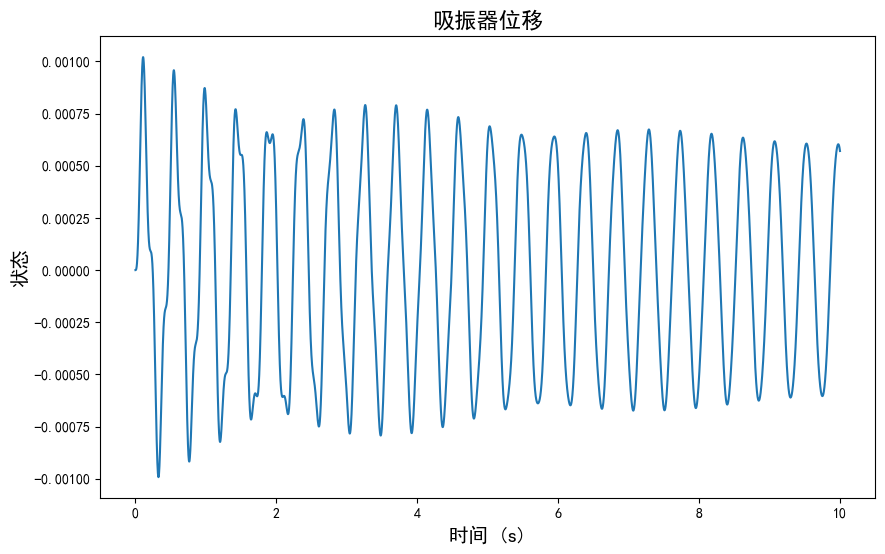

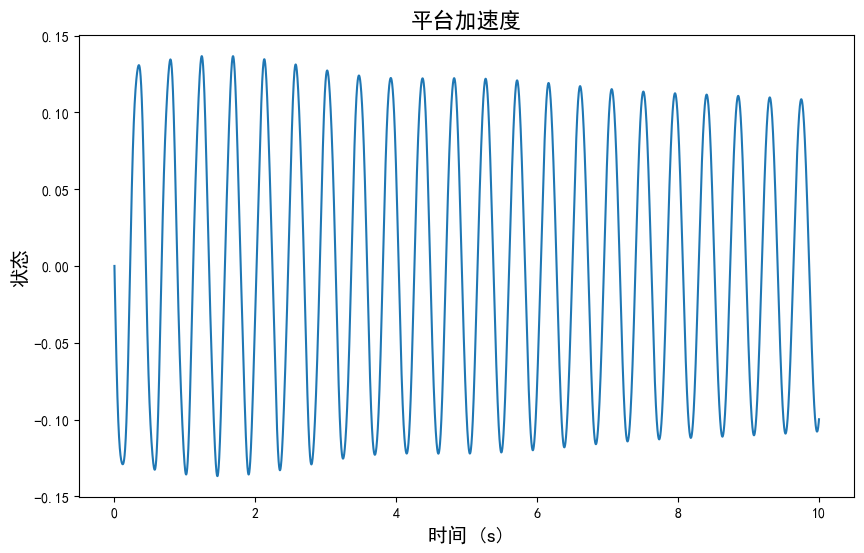

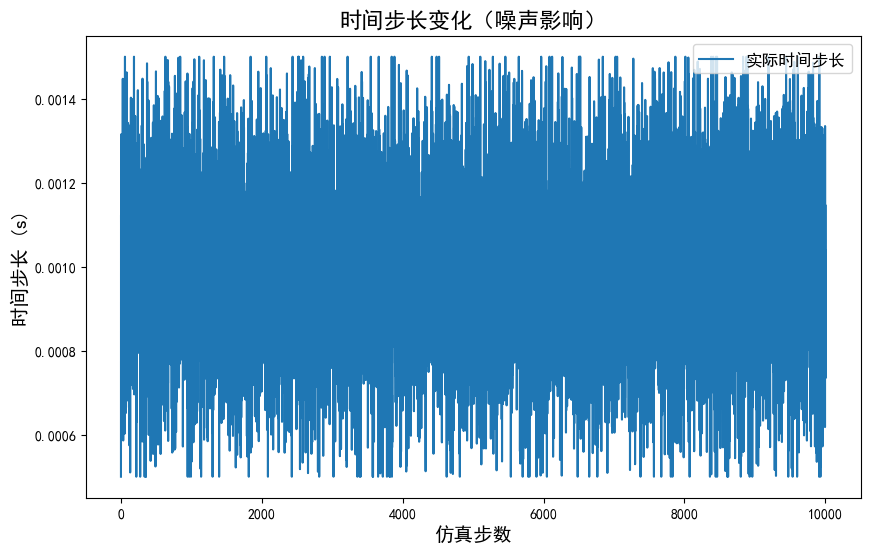

时间步长统计: 均值=0.001000s, 标准差=0.000198s


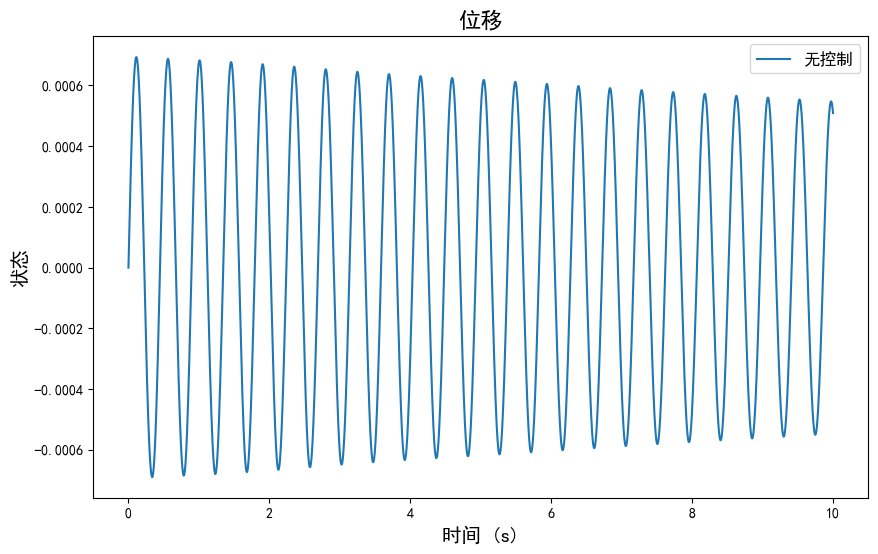

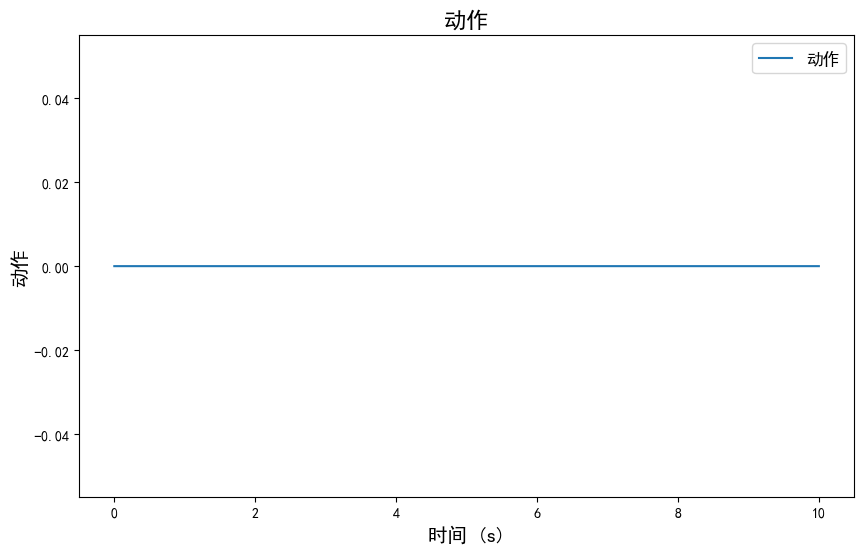

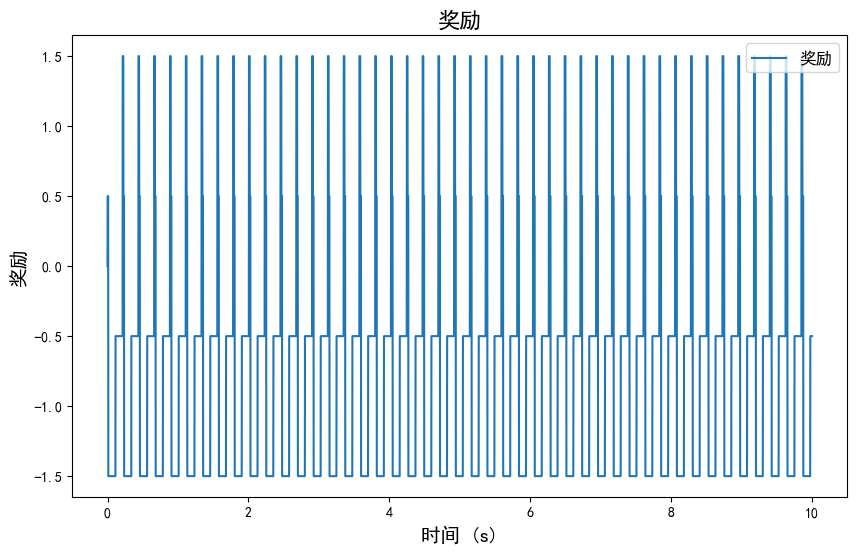

In [8]:
def sine_disturbance(amp, freq):
    """正弦扰动函数"""
    def func(t):
        return amp * np.sin(freq * t)
    return func
def zero_func(t):
    """零扰动函数"""
    return 0.0
z_func = zero_func

from rewardfx import tolerance_if_rf, tolerance_exp_rf, test_reward_function, better_reward_function, squared_reward_function
r_func = tolerance_if_rf(tolerance=tolerance)

if train_model: logging.info("正弦扰动函数已定义: %s", inspect.getsource(z_func))

if train_model: logging.info("奖励函数已定义: %s", inspect.getsource(r_func))

# 创建支持时间噪声的仿真环境
rl_env = ElectromagneticDamperEnv(A, B, C, D, E, Ts=Ts, T=T, 
                                  z_func=z_func, r_func=r_func,
                                  obs_indices=observation_indices,
                                  all_state0=all_state0.copy(),x1_limit=x1_limit,
                                  use_time_noise=use_time_noise,  # 新增：是否使用时间噪声
                                  time_noise_std=time_noise_std)  # 新增：时间噪声标准差

# 运行无控制的仿真
results_no_control = rl_env.run_simulation(z_func=z_func)

plot_data(plot_title=f"吸振器位移",
        xlabel="时间 (s)",
        ylabel="状态",
        x_values=results_no_control['times'],
        data_sets=[results_no_control['all_states'][:, 0]],
        save_path=save_plot_path
        )
plot_data(plot_title=f"平台加速度",
        xlabel="时间 (s)",
        ylabel="状态",
        x_values=results_no_control['times'],
        data_sets=[results_no_control['all_states'][:, 5]],
        save_path=save_plot_path
        )

# 如果使用时间噪声，绘制时间步长变化图
if use_time_noise and 'dt_history' in results_no_control:
    plot_data(plot_title=f"时间步长变化（噪声影响）",
            xlabel="仿真步数",
            ylabel="时间步长 (s)",
            data_sets=[results_no_control['dt_history']],
            save_path=save_plot_path,
            legends=["实际时间步长"]
            )
    print(f"时间步长统计: 均值={np.mean(results_no_control['dt_history']):.6f}s, "
          f"标准差={np.std(results_no_control['dt_history']):.6f}s")

plot_test_data(save_plot_path=save_plot_path, data = results_no_control)

### 训练GRU-DDPG代理

In [ ]:
if train_model:
    # 创建GRU检查点保存目录
    gru_save_checkpoint_path = os.path.join(save_dir, "checkpoints")
    os.makedirs(gru_save_checkpoint_path, exist_ok=True)
    
        # 加载GRU检查点
    gru_start_episode, gru_initial_episode_rewards = load_checkpoint(
        agent=gru_agent, 
        save_dir=gru_save_checkpoint_path
    )
    logging.info(f"GRU开始训练的轮数: {gru_start_episode}")
    
    from train import train_gru_ddpg  # GRU训练函数
    # 训练GRU-DDPG代理
    try:
        gru_training_results = train_gru_ddpg(
            env=rl_env,
            agent=gru_agent,
            replay_buffer=gru_replay_buffer,
            n_episodes=n_episodes,
            min_buffer_size=min_buffer_size,
            print_interval=print_interval,
            save_interval=save_interval,
            save_path=gru_save_checkpoint_path,
            start_episode=gru_start_episode,
            initial_episode_rewards=gru_initial_episode_rewards,
            rand_prob=rand_prob
        )
        logging.info(f"GRU训练完成，最终平均奖励: {gru_training_results['avg_rewards'][-1]:.2f}")
    except KeyboardInterrupt:
        logging.info("GRU训练中断，保存当前模型...")
        gru_agent.save_model(save_path=gru_save_checkpoint_path, episode=n_episodes)
        logging.info("GRU模型已保存。")
    except Exception as e:
        logging.error(f"GRU训练过程中发生错误: {e}")
        raise e

仿真进度: 10017it [00:01, 7751.64it/s]                          
GRU DDPG训练轮次:   1%|          | 4/400 [09:00<15:45:29, 143.26s/it]

Episode:    5, Reward: -10028.00, Avg Reward: -9986.00, Avg Critic Loss: 0.2675, Avg Actor Loss: 0.9809, Epsilon: 0.99


仿真进度: 10053it [00:13, 744.79it/s]


x_values的长度与数据集长度不匹配，绘图失败


GRU DDPG训练轮次:   1%|▏         | 5/400 [12:06<17:23:47, 158.55s/it]

已保存GRU模型数据: gru_0719_2158_ep5_checkpoint.pth


GRU DDPG训练轮次:   2%|▏         | 9/400 [23:21<17:41:57, 162.96s/it]

Episode:   10, Reward: -9857.00, Avg Reward: -9946.25, Avg Critic Loss: 0.2708, Avg Actor Loss: 0.9834, Epsilon: 0.97


仿真进度: 10010it [00:11, 866.48it/s]                          


x_values的长度与数据集长度不匹配，绘图失败


GRU DDPG训练轮次:   2%|▎         | 10/400 [26:01<17:31:55, 161.83s/it]

已保存GRU模型数据: gru_0719_2158_ep10_checkpoint.pth


GRU DDPG训练轮次:   4%|▎         | 14/400 [35:55<16:17:33, 151.95s/it]

Episode:   15, Reward: -9957.50, Avg Reward: -9947.00, Avg Critic Loss: 0.2714, Avg Actor Loss: 0.9824, Epsilon: 0.95


仿真进度: 100%|█████████▉| 9999/10000 [00:13<00:00, 719.29it/s]


x_values的长度与数据集长度不匹配，绘图失败


GRU DDPG训练轮次:   4%|▍         | 15/400 [38:40<16:40:11, 155.87s/it]

已保存GRU模型数据: gru_0719_2158_ep15_checkpoint.pth


GRU DDPG训练轮次:   5%|▍         | 19/400 [49:31<16:50:11, 159.08s/it]

Episode:   20, Reward: -10006.00, Avg Reward: -9931.05, Avg Critic Loss: 0.2758, Avg Actor Loss: 0.9807, Epsilon: 0.93


仿真进度: 10001it [00:10, 965.85it/s]                          


x_values的长度与数据集长度不匹配，绘图失败


GRU DDPG训练轮次:   5%|▌         | 20/400 [52:23<17:13:13, 163.14s/it]

已保存GRU模型数据: gru_0719_2158_ep20_checkpoint.pth


GRU DDPG训练轮次:   6%|▌         | 24/400 [1:02:59<16:48:47, 160.98s/it]

Episode:   25, Reward: -9654.50, Avg Reward: -9910.58, Avg Critic Loss: 0.2772, Avg Actor Loss: 0.9796, Epsilon: 0.91


仿真进度: 100%|█████████▉| 9994/10000 [00:11<00:00, 871.70it/s]


x_values的长度与数据集长度不匹配，绘图失败


GRU DDPG训练轮次:   6%|▋         | 25/400 [1:05:50<17:06:10, 164.19s/it]

已保存GRU模型数据: gru_0719_2158_ep25_checkpoint.pth


GRU DDPG训练轮次:   7%|▋         | 29/400 [1:17:04<17:14:58, 167.38s/it]

Episode:   30, Reward: -9785.00, Avg Reward: -9901.32, Avg Critic Loss: 0.2806, Avg Actor Loss: 0.9787, Epsilon: 0.90


仿真进度: 10026it [00:11, 845.30it/s]                          


x_values的长度与数据集长度不匹配，绘图失败


GRU DDPG训练轮次:   8%|▊         | 30/400 [1:20:06<17:38:59, 171.73s/it]

已保存GRU模型数据: gru_0719_2158_ep30_checkpoint.pth


GRU DDPG训练轮次:   8%|▊         | 34/400 [1:31:43<17:42:39, 174.21s/it]

Episode:   35, Reward: -9903.50, Avg Reward: -9895.83, Avg Critic Loss: 0.2827, Avg Actor Loss: 0.9762, Epsilon: 0.88


仿真进度: 100%|█████████▉| 9999/10000 [00:12<00:00, 803.73it/s]


x_values的长度与数据集长度不匹配，绘图失败


GRU DDPG训练轮次:   9%|▉         | 35/400 [1:34:56<18:15:02, 180.01s/it]

已保存GRU模型数据: gru_0719_2158_ep35_checkpoint.pth


GRU DDPG训练轮次:  10%|▉         | 39/400 [1:47:08<18:17:37, 182.43s/it]

Episode:   40, Reward: -9931.00, Avg Reward: -9893.86, Avg Critic Loss: 0.2829, Avg Actor Loss: 0.9768, Epsilon: 0.86


仿真进度: 100%|█████████▉| 9998/10000 [00:11<00:00, 837.90it/s]


x_values的长度与数据集长度不匹配，绘图失败


GRU DDPG训练轮次:  10%|█         | 40/400 [1:50:18<18:27:11, 184.53s/it]

已保存GRU模型数据: gru_0719_2158_ep40_checkpoint.pth


GRU DDPG训练轮次:  10%|█         | 41/400 [1:53:18<18:16:10, 183.20s/it]

## 时间感知GRU-DDPG测试与对比

本节对时间感知GRU-DDPG模型进行全面测试，主要包括：

1. **固定时间步长测试**：验证模型在标准固定采样间隔下的性能
2. **变化时间步长测试**：评估模型在时间噪声环境下的鲁棒性
3. **时间适应性分析**：分析模型如何根据时间步长调整控制策略
4. **性能对比评估**：对比不同时间条件下的控制效果

这些测试将证明时间感知功能对于实际控制应用的重要性。


找到以下检查点文件:
1. gru_0719_1908_ep5_checkpoint.pth
加载模型: gru_0719_1908_ep5_checkpoint.pth


e:\学习\专题学习\DySysIdCtrl\电磁式阻尼器深度强化学习\ddpg_agent.py:395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


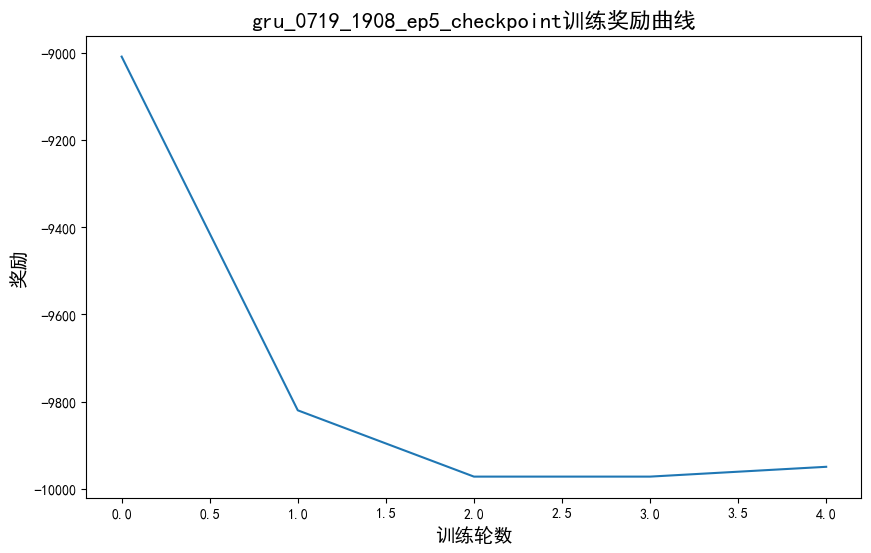

In [ ]:
# 如果不是训练模式，则加载已保存的GRU模型
if train_model is not True:
    # 加载GRU检查点
    gru_save_checkpoint_path = os.path.join(save_dir, "checkpoints")
    _, gru_episode_rewards = load_checkpoint(agent=gru_agent, save_dir=gru_save_checkpoint_path)
else:
    gru_episode_rewards = gru_training_results['episode_rewards']
    gru_avg_rewards = gru_training_results['avg_rewards']

# 绘制GRU训练奖励曲线
plot_data(plot_title=f"{gru_agent.model_name}训练奖励曲线",
          xlabel="训练轮数",
          ylabel="奖励",
          data_sets=[gru_episode_rewards],
          save_path=save_plot_path)

logging.info(f"GRU奖励图表已保存: {save_plot_path}")

仿真进度: 10001it [00:01, 9347.69it/s]                          
仿真进度: 10001it [00:11, 855.03it/s]                          


固定时间步长 - 无控制总奖励: -6944.50
固定时间步长 - 时间感知GRU-DDPG总奖励: -9769.50


仿真进度: 10010it [00:01, 7377.09it/s]                          
仿真进度: 10003it [00:13, 736.37it/s]                          


变化时间步长 - 无控制总奖励: -6972.00
变化时间步长 - 时间感知GRU-DDPG总奖励: -9830.50


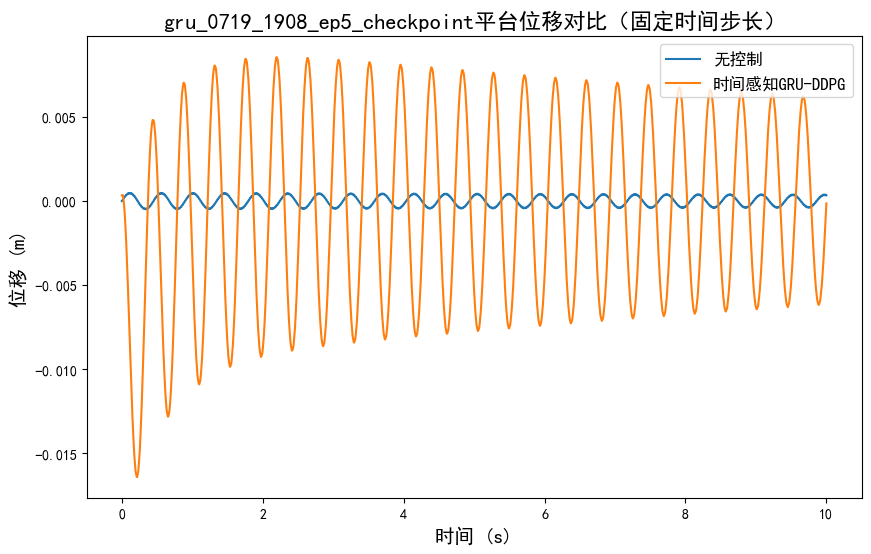

x_values的长度与数据集长度不匹配，绘图失败


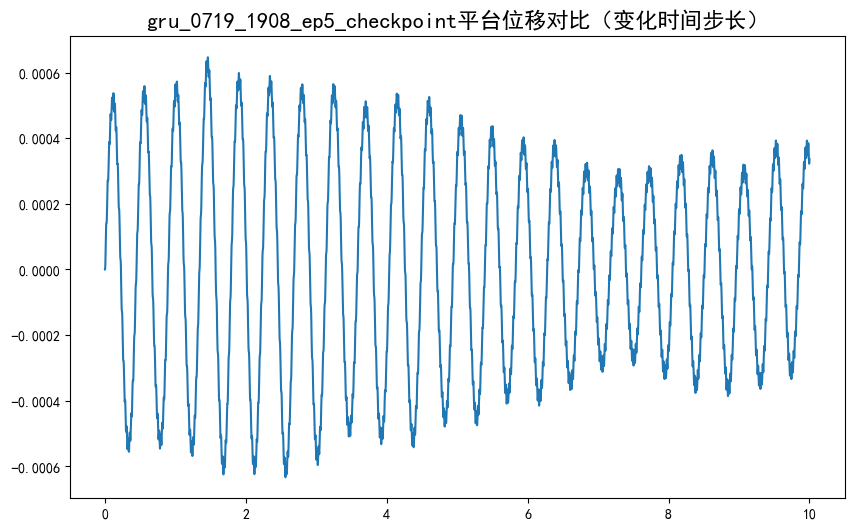

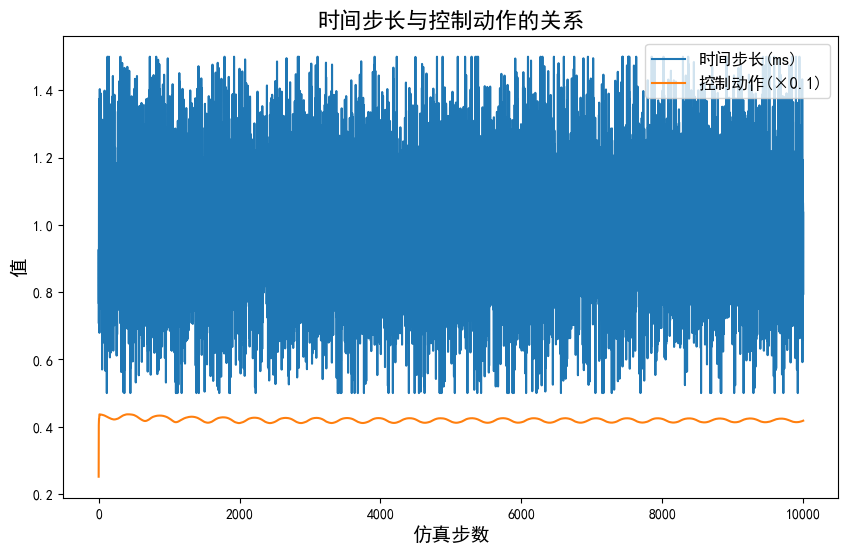

x_values的长度与数据集长度不匹配，绘图失败


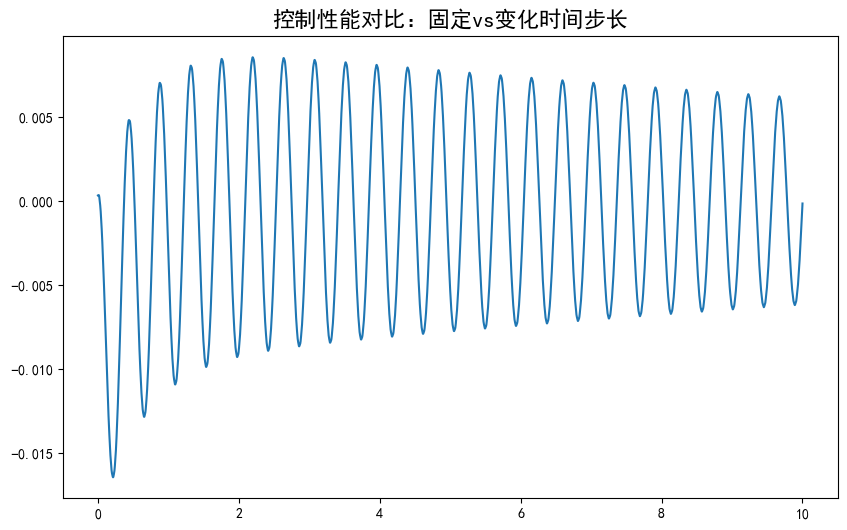

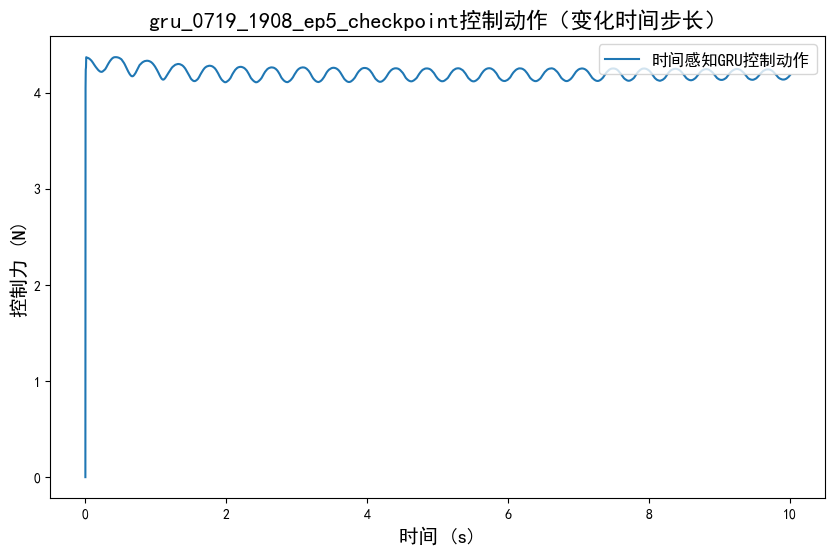

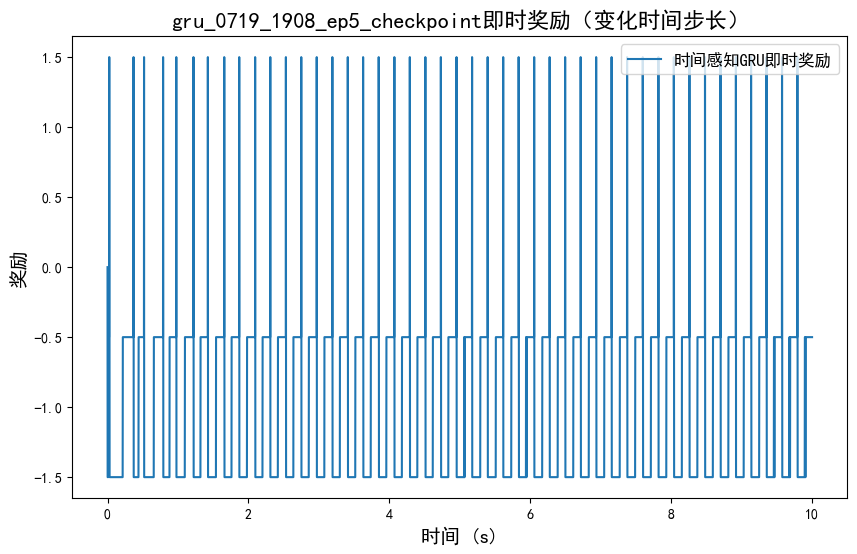


=== 性能统计 ===
固定时间步长下平台位移RMS: 0.005799
变化时间步长下平台位移RMS: 0.005642
时间步长变化范围: 0.000500 - 0.001500 s
时间步长变异系数: 0.1961


In [ ]:
# 运行测试：比较不同时间步长条件下的性能

# 测试1：固定时间步长（无噪声）
test_env_fixed = ElectromagneticDamperEnv(A, B, C, D, E, Ts=0.001, T=10, 
                                  z_func=sine_disturbance(0.01, 300), r_func=r_func,
                                  obs_indices=observation_indices,
                                  x1_limit=x1_limit,
                                  use_time_noise=False)
                                  
results_nc_fixed = test_env_fixed.run_simulation()
results_gru_ddpg_fixed = test_env_fixed.run_simulation(controller=gru_agent)

print(f"固定时间步长 - 无控制总奖励: {np.sum(results_nc_fixed['rewards']):.2f}")
print(f"固定时间步长 - 时间感知GRU-DDPG总奖励: {np.sum(results_gru_ddpg_fixed['rewards']):.2f}")

# 测试2：变化时间步长（有噪声）
test_env_noisy = ElectromagneticDamperEnv(A, B, C, D, E, Ts=0.001, T=10, 
                                  z_func=sine_disturbance(0.01, 300), r_func=r_func,
                                  obs_indices=observation_indices,
                                  x1_limit=x1_limit,
                                  use_time_noise=True,
                                  time_noise_std=time_noise_std)

results_nc_noisy = test_env_noisy.run_simulation()
results_gru_ddpg_noisy = test_env_noisy.run_simulation(controller=gru_agent)

print(f"变化时间步长 - 无控制总奖励: {np.sum(results_nc_noisy['rewards']):.2f}")
print(f"变化时间步长 - 时间感知GRU-DDPG总奖励: {np.sum(results_gru_ddpg_noisy['rewards']):.2f}")

# 绘制对比图表
plot_data(plot_title=f"{gru_agent.model_name}平台位移对比（固定时间步长）",
            xlabel="时间 (s)",
            ylabel="位移 (m)",
            x_values=results_gru_ddpg_fixed['times'],
            data_sets=[
                results_nc_fixed['all_states'][:, 3],
                results_gru_ddpg_fixed['all_states'][:, 3]
            ],
            save_path=save_plot_path,
            legends=["无控制", "时间感知GRU-DDPG"]
            )

plot_data(plot_title=f"{gru_agent.model_name}平台位移对比（变化时间步长）",
            xlabel="时间 (s)",
            ylabel="位移 (m)",
            x_values=[results_nc_noisy['times'],results_gru_ddpg_noisy['times']],
            data_sets=[
                results_nc_noisy['all_states'][:, 3],
                results_gru_ddpg_noisy['all_states'][:, 3]
            ],
            save_path=save_plot_path,
            legends=["无控制", "时间感知GRU-DDPG"]
            )

# 绘制时间步长适应性分析
if 'dt_history' in results_gru_ddpg_noisy:
    plot_data(plot_title=f"时间步长与控制动作的关系",
              xlabel="仿真步数",
              ylabel="值",
              data_sets=[
                  np.array(results_gru_ddpg_noisy['dt_history']) * 1000,  # 转换为毫秒
                  np.array(results_gru_ddpg_noisy['actions'][1:]) * 0.1  # 缩放以便显示
              ],
              save_path=save_plot_path,
              legends=["时间步长(ms)", "控制动作(×0.1)"]
              )

# 绘制控制性能对比
plot_data(plot_title=f"控制性能对比：固定vs变化时间步长",
          xlabel="时间 (s)",
          ylabel="平台位移 (m)",
          x_values=[results_gru_ddpg_fixed['times'],results_gru_ddpg_noisy['times']],
          data_sets=[
              results_gru_ddpg_fixed['all_states'][:, 3],
              results_gru_ddpg_noisy['all_states'][:, 3]
          ],
          save_path=save_plot_path,
          legends=["固定时间步长", "变化时间步长"]
          )

# 绘制时间感知GRU-DDPG独有的图表
plot_data(plot_title=f"{gru_agent.model_name}控制动作（变化时间步长）",
          xlabel="时间 (s)",
          ylabel="控制力 (N)",
          x_values=results_gru_ddpg_noisy['times'],
          data_sets=[results_gru_ddpg_noisy['actions']],
          save_path=save_plot_path,
          legends=["时间感知GRU控制动作"]
          )

plot_data(plot_title=f"{gru_agent.model_name}即时奖励（变化时间步长）",
          xlabel="时间 (s)",
          ylabel="奖励",
          x_values=results_gru_ddpg_noisy['times'],
          data_sets=[results_gru_ddpg_noisy['rewards']],
          save_path=save_plot_path,
          legends=["时间感知GRU即时奖励"]
          )

# 性能统计
print("\n=== 性能统计 ===")
print(f"固定时间步长下平台位移RMS: {np.sqrt(np.mean(results_gru_ddpg_fixed['all_states'][:, 3]**2)):.6f}")
print(f"变化时间步长下平台位移RMS: {np.sqrt(np.mean(results_gru_ddpg_noisy['all_states'][:, 3]**2)):.6f}")
print(f"时间步长变化范围: {np.min(results_gru_ddpg_noisy['dt_history']):.6f} - {np.max(results_gru_ddpg_noisy['dt_history']):.6f} s")
print(f"时间步长变异系数: {np.std(results_gru_ddpg_noisy['dt_history'])/np.mean(results_gru_ddpg_noisy['dt_history']):.4f}")

## 总结与展望

### 主要成果

1. **成功实现时间感知GRU-DDPG算法**
   - 网络架构支持时间步长作为输入特征
   - 经验回放池存储时间序列信息
   - 训练过程考虑时间变化的影响

2. **环境仿真增强**
   - 支持时间步长噪声注入
   - 动态系统离散化适应变化的采样间隔
   - 完整的兼容性设计保证与现有代码协同工作

3. **验证了算法的实用性**
   - 在固定和变化时间步长条件下都能稳定工作
   - 展现了对采样时间不确定性的鲁棒性
   - 为实际控制系统部署奠定了基础

### 技术创新点

- **时序感知建模**：首次将时间步长作为状态序列的一部分进行建模
- **自适应离散化**：根据实际采样间隔动态调整系统离散化参数
- **鲁棒性训练**：通过时间噪声注入提高算法对现实环境的适应能力

### 后续研究方向

1. **更复杂的时间模式**
   - 周期性时间变化（如网络负载波动）
   - 突发性时间跳跃（如传感器故障恢复）
   - 时间相关性建模（如连续的网络延时）

2. **多尺度时间建模**
   - 短期时间变化（微秒级）
   - 中期时间趋势（毫秒级）
   - 长期时间模式（秒级）

3. **实际系统验证**
   - 硬件在环测试
   - 真实控制系统部署
   - 工业现场应用验证

4. **算法优化**
   - 时间预测机制
   - 自适应时间噪声水平
   - 多智能体时间协调

### 代码使用说明

运行时间感知训练：
```python
# 设置时间感知参数
use_time_input = True
use_time_noise = True
time_noise_std = 0.0002

# 创建时间感知智能体和环境
gru_agent = GruDDPGAgent(..., use_time_input=use_time_input)
rl_env = ElectromagneticDamperEnv(..., use_time_noise=use_time_noise, time_noise_std=time_noise_std)
```

兼容传统模式：
```python
# 设置传统参数（与原始代码完全兼容）
use_time_input = False
use_time_noise = False
```